<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

## Keras NLP starter guide here: https://keras.io/guides/keras_nlp/getting_started/

__This starter notebook uses a transformer model trained from scratch with KerasNLP.__

Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models.


![Transformer Architecture](https://miro.medium.com/v2/resize:fit:856/1*ZCFSvkKtppgew3cc7BIaug.png)

This notebook contains complete code to train a transformer from scratch to perform a time serie prediction task.

**Our model will assign a mark from 0 to 6 to predict overall writing quality.**


In this notebook, you will:

- Load the KeystrokeLogging dataset
- Explore the dataset
- Preprocess the data
- Create a transformer from scratch using Keras NLP API
- Train your own model
- Generate the submission file


In [23]:
!pip install keras-core --upgrade
!pip install -q keras-nlp
!pip install seaborn

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt
import os

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.12.0
Keras version: 0.1.5
KerasNLP version: 0.6.1


# Load the Keystroke Logging dataset
Let's have a look at all the data files

In [53]:
DATA_DIR = '/kaggle/input/linking-writing-processes-to-writing-quality/'

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv
/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv
/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv
/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv


## Data dictionary

Let's dicover the data which are composed of :
- events
- activities
- scores

**Events**

| Column             | Definition                                                                |
| ------------------ | ------------------------------------------------------------------------- |
| essay_id_comp      | The unique ID of the essay                                                |
| event_id           | The index of the event, ordered chronologically                           |
| down_time          | The time of the down event in milliseconds                                |
| up_time            | The time of the up event in milliseconds                                  |
| action_time        | The duration of the event (the difference between down_time and up_time)  |
| activity           | The category of activity which the event belongs to                       |
| down_event         | The name of the event when the key/mouse is pressed                       |
| up_event           | The name of the event when the key/mouse is released                      |
| text_change        | The text that changed as a result of the event (if any)                   |
| cursor_position    | The character index of the text cursor after the event                    |
| word_count         | The word count of the essay after the event                               |

**Activities**

| Activity Name                  | Definition                                                                                 |
| ------------------------------ | ------------------------------------------------------------------------------------------ |
| Nonproduction                  | The event does not alter the text in any way                                               |
| Input                          | The event adds text to the essay                                                           |
| Remove/Cut                     | The event removes text from the essay                                                      |
| Paste                          | The event changes the text through a paste input                                           |
| Replace                        | The event replaces a section of text with another string                                   |
| Move From [x1, y1] To [x2, y2] | The event moves a section of text spanning character index x1, y1 to a new location x2, y2 |

**Scores**

| Column         | Definition                                                                        |
| -------------- | --------------------------------------------------------------------------------- |
| essay_id_comp  | The unique ID of the essay                                                        |
| score          | The score the essay received out of 6 (the prediction target for the competition) |
| split          | The train-test split of the essay                                                 |

# Explore the dataset

Let's look at the distribution of labels in the training set.

In [54]:
df_train_scores = pd.read_csv(DATA_DIR + "train_scores.csv")
df_train_scores.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


Text(0.5, 1.0, 'Distribution of scores')

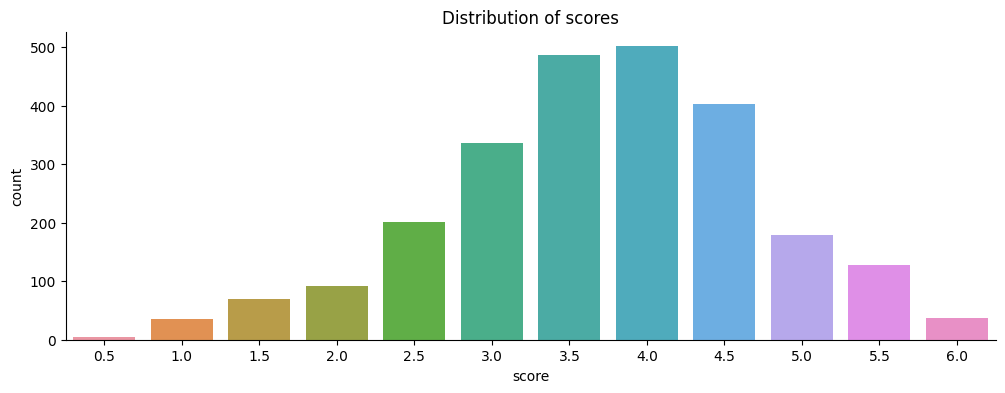

In [55]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_scores,
                   x="score")

ax.set_title("Distribution of scores")

# Event

In [56]:
df_train_logs = pd.read_csv(DATA_DIR + "train_logs.csv")
df_test_logs = pd.read_csv(DATA_DIR + "test_logs.csv")


print(df_train_logs.shape)
print(df_test_logs.shape)
df_train_logs.head()

(8405898, 11)
(6, 11)


,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


The average of the number of events per essay in the train dataset is : 1701.0
The average of the number of events per essay in the test dataset is : 2.0


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Distribution of the number of events per essay - Test dataset')

<Figure size 3000x1800 with 0 Axes>

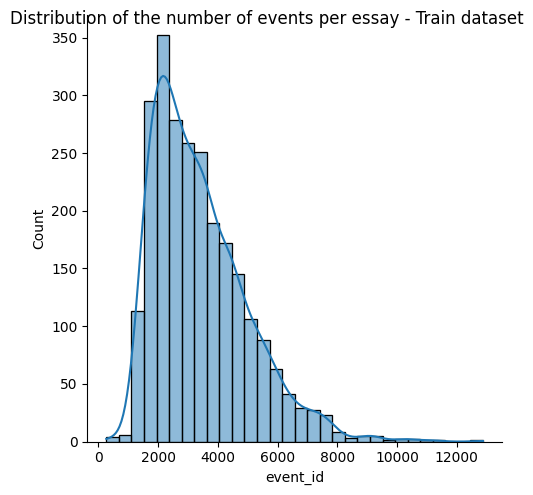

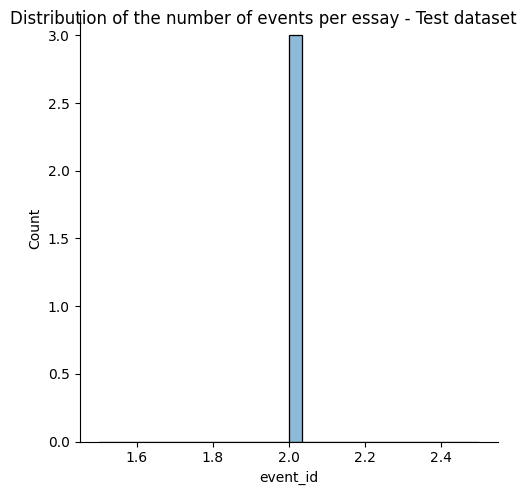

In [57]:
print('The average of the number of events per essay in the train dataset is : ' + str(df_train_logs.groupby("id").mean(numeric_only=True)["event_id"].mean().round(0)))
print('The average of the number of events per essay in the test dataset is : ' + str(df_test_logs.groupby("id").mean(numeric_only=True)["event_id"].mean().round(0)))

fig = plt.figure(figsize=(30,18))
plot = sns.displot(data=df_train_logs[["id","event_id"]].groupby("id").count(),
                 x="event_id", bins=30, kde=True)
plot.fig.suptitle("Distribution of the number of events per essay - Train dataset")

plot = sns.displot(df_test_logs[["id","event_id"]].groupby("id").count(),
                   x="event_id", bins=30, kde=True)
plot.fig.suptitle("Distribution of the number of events per essay - Test dataset")

Now, let's discover the events distribution.

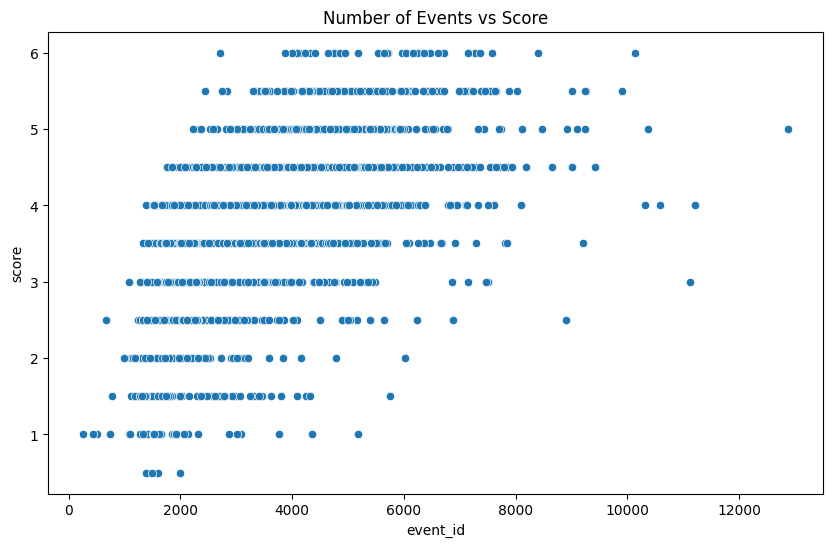

In [58]:
# Total number of events
df_train_logs['event_id'] = df_train_logs['event_id'].astype(int)
df_train_logs_grouped = df_train_logs.groupby('id').agg({'event_id': 'max'})

# Merge with train_scores
combined_df = pd.merge(df_train_scores, df_train_logs_grouped, left_on='id', right_index=True, how='left')

# Now you can create the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='event_id', y='score')
plt.title('Number of Events vs Score')
plt.show()

In [73]:
combined_df

,id,score,event_id
0,001519c8,3.5,2557
1,0022f953,3.5,2454
2,0042269b,6.0,4136
3,0059420b,2.0,1556
4,0075873a,4.0,2531
...,...,...,...
2466,ffb8c745,3.5,4739
2467,ffbef7e5,4.0,2604
2468,ffccd6fd,1.5,3063
2469,ffec5b38,5.0,3242


In [59]:
df_event_count = df_train_logs['up_event'].value_counts().to_frame().reset_index().sort_values(by='count', ascending=[False])
df_event_count

,up_event,count
0,q,5364789
1,Space,1207128
2,Backspace,964089
3,Shift,334227
4,ArrowRight,121338
...,...,...
117,F1,1
116,k,1
115,Pause,1
114,Â´,1


In [60]:
vocab_event = df_event_count["up_event"].values
vocab_event

array(['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick',
       'ArrowLeft', '.', ',', 'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock',
       "'", 'Delete', 'Unidentified', 'Control', '"', '-', '?', ';', '=',
       'Tab', '/', 'Rightclick', ':', '(', ')', '\\', 'ContextMenu',
       'End', '!', 'Meta', 'Alt', 'c', '[', 'v', 'NumLock', 'Insert',
       'Home', 'z', 'a', 'AudioVolumeDown', 'F2', 'x', 't',
       'AudioVolumeUp', '$', 'i', '>', ']', 's', '*', '%', 'w', '&',
       'Dead', 'm', 'Escape', 'ModeChange', 'F3', '<', 'AudioVolumeMute',
       '+', 'o', 'F15', 'ScrollLock', 'PageDown', 'Process', 'h', 'b',
       'e', 'p', '_', 'f', '{', 'PageUp', '`', 'r', '#', '0', '1',
       'Middleclick', 'F12', '5', '\x97', 'OS', '@', 'n', 'y', 'g', 'F11',
       'Ä±', 'MediaTrackNext', 'l', 'Clear', 'MediaPlayPause', 'd', 'V',
       'j', 'u', 'â\x80\x93', '}', '~', 'AltGraph', '2', '|',
       'Unknownclick', 'A', 'MediaTrackPrevious', '^', '\x96', '¿', '¡',
       'M', 'S', '

In [63]:
# Filter for non-input, non-nonproduction activities
df_edits = df_train_logs[(df_train_logs['activity'] != 'Input') & (df_train_logs['activity'] != 'Nonproduction')]

# Count the number of edits per essay
num_edits_per_essay_train = df_edits.groupby("id").size()
num_edits_per_essay_test = df_test_logs[(df_test_logs['activity'] != 'Input') & (df_test_logs['activity'] != 'Nonproduction')].groupby("id").size()


In [64]:
# Filter for input activities
df_inputs = df_train_logs[df_train_logs['activity'] == 'Input']

# Calculate typing speed
typing_speed_train = df_inputs.groupby("id").apply(lambda g: (g["up_time"] - g["down_time"]).sum() / g.shape[0])
typing_speed_test = df_test_logs[df_test_logs['activity'] == 'Input'].groupby("id").apply(lambda g: (g["up_time"] - g["down_time"]).sum() / g.shape[0])


In [66]:
num_edits_per_essay_train
typing_speed_train

id
001519c8    121.259204
0022f953    122.750774
0042269b    100.631010
0059420b    128.673313
0075873a    137.237384
               ...    
ffb8c745    119.005017
ffbef7e5     84.928184
ffccd6fd     75.351702
ffec5b38     90.920898
fff05981     93.674551
Length: 2471, dtype: float64

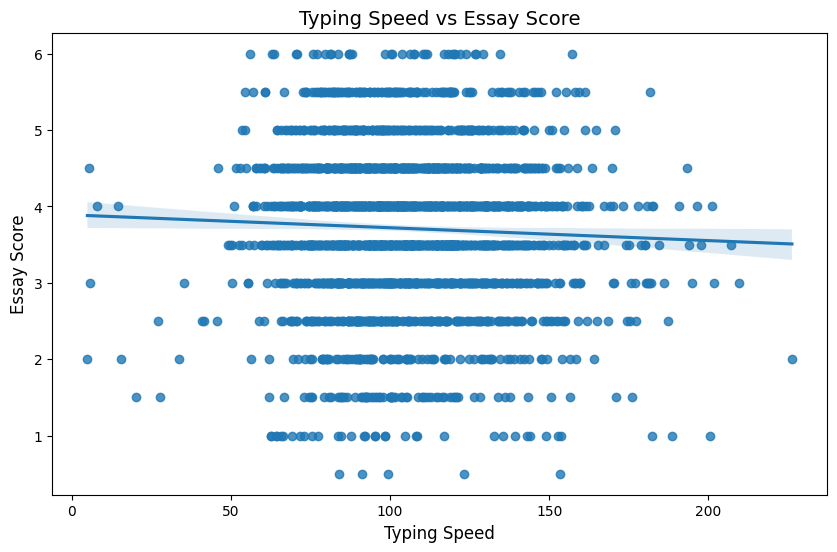

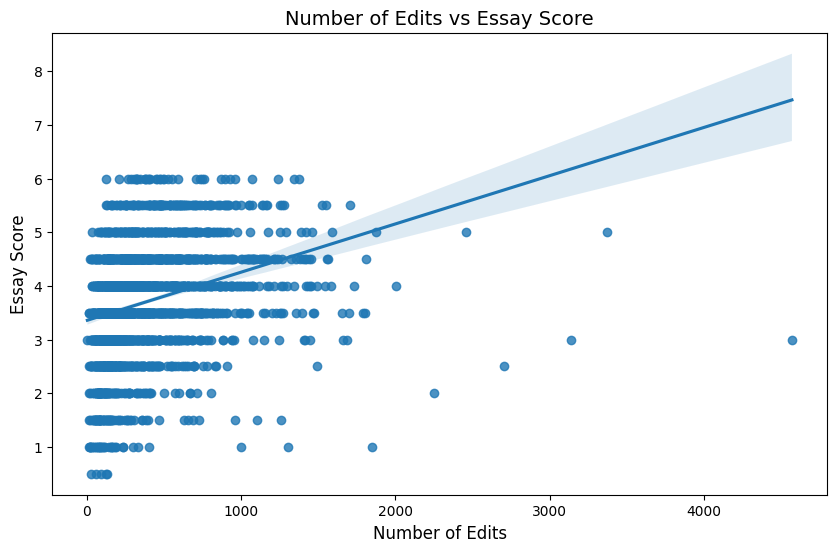

In [83]:

# Merge typing_speed_train and df_train_scores
merged_df = typing_speed_train.reset_index().rename(columns={0: 'typing_speed'}).merge(df_train_scores, on='id')

# Add num_edits to merged_df
merged_df['num_edits'] = num_edits_per_essay_train.reset_index().rename(columns={'id': 'id', 0: 'num_edits'})['num_edits']

# Create scatter plot for typing speed
plt.figure(figsize=(10, 6)) # Adjust the size of the figure
sns.regplot(x='typing_speed', y='score', data=merged_df)
plt.title('Typing Speed vs Essay Score', fontsize=14) # Adjust the font size of the title
plt.xlabel('Typing Speed', fontsize=12) # Adjust the font size of the x-label
plt.ylabel('Essay Score', fontsize=12) # Adjust the font size of the y-label
plt.show()

# Create scatter plot for number of edits
plt.figure(figsize=(10, 6)) # Adjust the size of the figure
sns.regplot(x='num_edits', y='score', data=merged_df)
plt.title('Number of Edits vs Essay Score', fontsize=14) # Adjust the font size of the title
plt.xlabel('Number of Edits', fontsize=12) # Adjust the font size of the x-label
plt.ylabel('Essay Score', fontsize=12) # Adjust the font size of the y-label
plt.show()


From these plots, it appears that typing speed doesn't correlate with essay score but the number of edits may. 

# Prepare data

Let's create the sentences for the transformer model.

First, pivot the table

In [85]:
SEQ_LENGTH = 1700
df_train_prepared_logs = df_train_logs[['id','event_id', 'up_event']][df_train_logs['event_id'] < SEQ_LENGTH]

df_train_prepared_logs = pd.pivot_table(data= df_train_prepared_logs, index='id', columns='event_id', values='up_event', fill_value='', aggfunc='first')
df_train_prepared_logs

event_id,1,2,3,4,5,6,7,8,9,10,...,1690,1691,1692,1693,1694,1695,1696,1697,1698,1699
id,,,,,,,,,,,,,,,,,,,,,
001519c8,Leftclick,Leftclick,Shift,q,q,q,q,q,q,Space,...,q,q,q,q,q,Space,Backspace,.,Space,Space
0022f953,Leftclick,Shift,q,q,q,q,Space,q,q,Space,...,Shift,q,q,q,q,q,q,Space,q,q
0042269b,Leftclick,Shift,q,q,q,q,q,q,q,Space,...,q,q,q,q,q,q,q,Space,q,q
0059420b,Leftclick,Leftclick,Shift,Shift,Shift,Shift,Shift,Shift,Shift,Shift,...,,,,,,,,,,
0075873a,Leftclick,Shift,q,q,q,q,q,q,q,q,...,Space,q,q,q,Space,q,q,q,q,q
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffb8c745,Leftclick,Tab,Leftclick,Space,Space,Space,Space,Space,Shift,q,...,Backspace,Backspace,Backspace,Backspace,Backspace,Backspace,Backspace,q,q,q
ffbef7e5,Leftclick,Leftclick,Shift,q,q,q,q,Space,q,q,...,q,q,q,q,q,.,Space,Shift,q,Space
ffccd6fd,Leftclick,Leftclick,q,q,q,q,q,q,Space,q,...,Space,Space,Space,Space,Space,Space,Space,Space,Space,Space


Then, create a new column with the input text by concatening all event columns

In [86]:
df_train_prepared_logs["text"] = ""
for i in range(1, 1700):
    df_train_prepared_logs["text"] = df_train_prepared_logs["text"] + " " + df_train_prepared_logs[i]
    
df_train_prepared_logs["text"] = df_train_prepared_logs["text"].apply(lambda x : x.strip())
df_train_prepared_logs

event_id,1,2,3,4,5,6,7,8,9,10,...,1691,1692,1693,1694,1695,1696,1697,1698,1699,text
id,,,,,,,,,,,,,,,,,,,,,
001519c8,Leftclick,Leftclick,Shift,q,q,q,q,q,q,Space,...,q,q,q,q,Space,Backspace,.,Space,Space,Leftclick Leftclick Shift q q q q q q Space q ...
0022f953,Leftclick,Shift,q,q,q,q,Space,q,q,Space,...,q,q,q,q,q,q,Space,q,q,Leftclick Shift q q q q Space q q Space Shift ...
0042269b,Leftclick,Shift,q,q,q,q,q,q,q,Space,...,q,q,q,q,q,q,Space,q,q,Leftclick Shift q q q q q q q Space q q q Spac...
0059420b,Leftclick,Leftclick,Shift,Shift,Shift,Shift,Shift,Shift,Shift,Shift,...,,,,,,,,,,Leftclick Leftclick Shift Shift Shift Shift Sh...
0075873a,Leftclick,Shift,q,q,q,q,q,q,q,q,...,q,q,q,Space,q,q,q,q,q,Leftclick Shift q q q q q q q q q q q Space q ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffb8c745,Leftclick,Tab,Leftclick,Space,Space,Space,Space,Space,Shift,q,...,Backspace,Backspace,Backspace,Backspace,Backspace,Backspace,q,q,q,Leftclick Tab Leftclick Space Space Space Spac...
ffbef7e5,Leftclick,Leftclick,Shift,q,q,q,q,Space,q,q,...,q,q,q,q,.,Space,Shift,q,Space,Leftclick Leftclick Shift q q q q Space q q q ...
ffccd6fd,Leftclick,Leftclick,q,q,q,q,q,q,Space,q,...,Space,Space,Space,Space,Space,Space,Space,Space,Space,Leftclick Leftclick q q q q q q Space q q q q ...


In [98]:
# Make sure that the id in num_edits_per_essay_train matches the id in df_train_prepared_logs
assert set(num_edits_per_essay_train.index) == set(df_train_prepared_logs.index)

# Assign num_edits_per_essay_train to df_train_prepared_logs
df_train_prepared_logs['num_edits'] = num_edits_per_essay_train
df_train_prepared_logs


event_id,1,2,3,4,5,6,7,8,9,10,...,1692,1693,1694,1695,1696,1697,1698,1699,text,num_edits
id,,,,,,,,,,,,,,,,,,,,,
001519c8,Leftclick,Leftclick,Shift,q,q,q,q,q,q,Space,...,q,q,q,Space,Backspace,.,Space,Space,Leftclick Leftclick Shift q q q q q q Space q ...,427
0022f953,Leftclick,Shift,q,q,q,q,Space,q,q,Space,...,q,q,q,q,q,Space,q,q,Leftclick Shift q q q q Space q q Space Shift ...,262
0042269b,Leftclick,Shift,q,q,q,q,q,q,q,Space,...,q,q,q,q,q,Space,q,q,Leftclick Shift q q q q q q q Space q q q Spac...,446
0059420b,Leftclick,Leftclick,Shift,Shift,Shift,Shift,Shift,Shift,Shift,Shift,...,,,,,,,,,Leftclick Leftclick Shift Shift Shift Shift Sh...,153
0075873a,Leftclick,Shift,q,q,q,q,q,q,q,q,...,q,q,Space,q,q,q,q,q,Leftclick Shift q q q q q q q q q q q Space q ...,517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffb8c745,Leftclick,Tab,Leftclick,Space,Space,Space,Space,Space,Shift,q,...,Backspace,Backspace,Backspace,Backspace,Backspace,q,q,q,Leftclick Tab Leftclick Space Space Space Spac...,962
ffbef7e5,Leftclick,Leftclick,Shift,q,q,q,q,Space,q,q,...,q,q,q,.,Space,Shift,q,Space,Leftclick Leftclick Shift q q q q Space q q q ...,61
ffccd6fd,Leftclick,Leftclick,q,q,q,q,q,q,Space,q,...,Space,Space,Space,Space,Space,Space,Space,Space,Leftclick Leftclick q q q q q q Space q q q q ...,88


Create the `vocab` list and use the `TextVectorization` layer to convert each event into integer.

In [109]:
vocab = vocab_event.tolist() 
VOCAB_SIZE = len(vocab)

# After this layer, we have a tensor of shape (batch_size, max_len) containing vocab indices.  
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens = len(vocab) + 2,
                                 output_mode='int',
                                 standardize=None,
                                 split="whitespace",
                                 vocabulary=vocab,                   
                                 output_sequence_length=1700)

vectorize_layer.get_vocabulary()

['',
 '[UNK]',
 'q',
 'Space',
 'Backspace',
 'Shift',
 'ArrowRight',
 'Leftclick',
 'ArrowLeft',
 '.',
 ',',
 'ArrowDown',
 'ArrowUp',
 'Enter',
 'CapsLock',
 "'",
 'Delete',
 'Unidentified',
 'Control',
 '"',
 '-',
 '?',
 ';',
 '=',
 'Tab',
 '/',
 'Rightclick',
 ':',
 '(',
 ')',
 '\\',
 'ContextMenu',
 'End',
 '!',
 'Meta',
 'Alt',
 'c',
 '[',
 'v',
 'NumLock',
 'Insert',
 'Home',
 'z',
 'a',
 'AudioVolumeDown',
 'F2',
 'x',
 't',
 'AudioVolumeUp',
 '$',
 'i',
 '>',
 ']',
 's',
 '*',
 '%',
 'w',
 '&',
 'Dead',
 'm',
 'Escape',
 'ModeChange',
 'F3',
 '<',
 'AudioVolumeMute',
 '+',
 'o',
 'F15',
 'ScrollLock',
 'PageDown',
 'Process',
 'h',
 'b',
 'e',
 'p',
 '_',
 'f',
 '{',
 'PageUp',
 '`',
 'r',
 '#',
 '0',
 '1',
 'Middleclick',
 'F12',
 '5',
 '\x97',
 'OS',
 '@',
 'n',
 'y',
 'g',
 'F11',
 'Ä±',
 'MediaTrackNext',
 'l',
 'Clear',
 'MediaPlayPause',
 'd',
 'V',
 'j',
 'u',
 'â\x80\x93',
 '}',
 '~',
 'AltGraph',
 '2',
 '|',
 'Unknownclick',
 'A',
 'MediaTrackPrevious',
 '^',
 '\x96',

In [113]:
# Create the X and Y
tokens_ids = vectorize_layer(df_train_prepared_logs["text"])

len_df_train = df_train_prepared_logs["text"].shape[0]
labels = tf.reshape(tf.convert_to_tensor(df_train_scores["score"].values), (len_df_train, 1))

# Create the model

In [114]:
token_id_input = keras.Input(
    shape=(SEQ_LENGTH,),
    dtype="int32"
)

# A layer which sums a token and position embedding
outputs_tok_pos_emb = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length=SEQ_LENGTH,
    embedding_dim=32,
)(token_id_input)

# Follows the architecture of the transformer encoder layer in the paper Attention is All You Need.
# Users can instantiate multiple instances of this class to stack up an encoder.
outputs_transf_enc1 = keras_nlp.layers.TransformerEncoder(num_heads=6,
                                                         intermediate_dim=128,
                                                         dropout=0.1)(outputs_tok_pos_emb)
outputs_transf_enc2 = keras_nlp.layers.TransformerEncoder(num_heads=6,
                                                         intermediate_dim=128,
                                                         dropout=0.1)(outputs_transf_enc1)
outputs_transf_enc3 = keras_nlp.layers.TransformerEncoder(num_heads=6,
                                                         intermediate_dim=128,
                                                         dropout=0.1)(outputs_transf_enc2)

# Add the classifier header
outputs = keras.layers.Dense(1)(outputs_transf_enc3[:, 0, :])


model = keras.Model(
    inputs=token_id_input,
    outputs=outputs,
)

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1700)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ token_and_position_embedding_4  │ (None, 1700, 32)          │     58,560 │
│ (TokenAndPositionEmbedding)     │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_encoder_12          │ (None, 1700, 32)          │     12,442 │
│ (TransformerEncoder)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_encoder_13          │ (None, 1700, 32)          │     12,442 │
│ (TransformerEncoder)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_encoder_14          │ (None, 1700, 32)          │     12,442 │
│ (TransformerEncoder)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ get_item_4 (GetItem)            │ (None, 32)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_34 (Dense)                │ (None, 1)                 │         33 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 95,919 (374.68 KB)

 Trainable params: 95,919 (374.68 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Convert num_edits to a tensor
num_edits_ids = tf.convert_to_tensor(df_train_prepared_logs["num_edits"].values)
num_edits_ids = tf.reshape(num_edits_ids, (len_df_train, 1))

outputs_tokens = keras.layers.Dense(1)(outputs_transf_enc3[:, 0, :])
outputs_num_edits = keras.layers.Dense(1)(outputs_transf_enc3[:, 0, :])

model = keras.Model(
   inputs=token_id_input,
   outputs=[outputs_tokens, outputs_num_edits],
)


In [ ]:
model.compile(
    loss=keras.losses.mean_squared_error,
    optimizer=keras.optimizers.AdamW(5e-4),
    metrics=[keras.metrics.RootMeanSquaredError(), keras.metrics.RootMeanSquaredError()],
    jit_compile=True,
)

model.fit(
    batch_size=32,
    shuffle=True,
    x = tokens_ids,
    y = [labels, num_edits_ids],
    epochs=20
)

Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 61s 501ms/step - dense_35_root_mean_squared_error: 2.7157 - dense_36_root_mean_squared_error: 510.3247 - loss: 260951.1877
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 27s 348ms/step - dense_35_root_mean_squared_error: 1.6490 - dense_36_root_mean_squared_error: 496.0563 - loss: 246477.2660
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 27s 347ms/step - dense_35_root_mean_squared_error: 1.1045 - dense_36_root_mean_squared_error: 511.0670 - loss: 261360.0053
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 27s 347ms/step - dense_35_root_mean_squared_error: 1.0801 - dense_36_root_mean_squared_error: 526.4093 - loss: 277481.1149
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 27s 347ms/step - dense_35_root_mean_squared_error: 1.0547 - dense_36_root_mean_squared_error: 498.3358 - loss: 248528.8697
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 27s 347ms/step - dense_35_root_mean_squared_error: 1.0073 - dense_36_root_mean_squared_error: 522.4936 - loss: 274127.5676
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━

In [ ]:
for tok, lbl, idx in zip(tokens_ids, labels, range(15)):
    print(lbl.numpy(), model.predict(tf.expand_dims(tok, axis=0)))

# Generate the submission file

Let's prepare the test data and do the predictions

In [ ]:
df_test_prepared_logs = pd.pivot_table(data= df_test_logs, index='id', columns='event_id', values='up_event', fill_value='', aggfunc='first')

df_test_prepared_logs["text"] = ""
for i in range(1, 3):
    df_test_prepared_logs["text"] = df_test_prepared_logs["text"] + " " + df_test_prepared_logs[i]
    
df_test_prepared_logs["text"] = df_test_prepared_logs["text"].apply(lambda x : x.strip())

test_token_ids = vectorize_layer(df_test_prepared_logs["text"])
test_token_ids

In [ ]:
predictions = model.predict(test_token_ids)

In [ ]:
submission = pd.DataFrame({'id': df_test_prepared_logs.index.values, 'score' : np.squeeze(predictions)})

In [ ]:
submission.to_csv("submission.csv", index=False)